<a href="https://colab.research.google.com/github/rahul94jh/MSC-Research/blob/main/Seq_finetuning_YouTube_clickbait_rmsprop_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

Some good reads https://www.jeremyjordan.me/nn-learning-rate/ 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Check GPU, if assigned k8 then factory reset couple of times until we get Tesla GPU
!nvidia-smi

Fri Jul 23 07:41:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install -q tensorflow-text
!pip install -q tf-models-official

#Imports

In [5]:
import os, math
import numpy as np
import pandas as pd
import requests
import shutil
import re
from pathlib import Path
import random
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score



import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop


from tensorflow import keras
from official.nlp import optimization  # to create AdamW optmizer
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

tf.get_logger().setLevel('ERROR')

import sys

#Import custom script
sys.path.append('/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/scripts')
from tf_dataset_helpers import read_tfrec_data
import model_helpers as mh
import visualization_helpers as vh

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [6]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


#Configs

##General config

In [64]:
tfrec_trainVal_files_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/tfrec_data/train_val/'
tfrec_test_files_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/tfrec_data/test/'
stop_clickbait_tfrecFiles_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/Stop_clickbait/tfrec_data/'
fvc_clickbait_tfrecFiles_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/FVC_CORPUS/tfrec_data/'
tfrec_benchmark_files_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/tfrec_data/'

model_root_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/saved_models'
saved_model_name = f'youtube_clickbait_finetuned_SEQ_all'
saved_model_path = os.path.join(model_root_path, saved_model_name )

checkpoint_root_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/checkpoints/youtube_clickbait_finetuned_SEQ_all'
if not os.path.exists(checkpoint_root_path):
    os.makedirs(checkpoint_root_path)
model_checkpoint_path = os.path.join(checkpoint_root_path, f'youtube_clickbait_finetuned_SEQ_all_checkpoint' )

MAX_LEN = 128
VOCAB_SIZE = 20000
BATCH_SIZE = 64  
# Label categories
label_list = [0,1]

init_lr = 0.5e-1
end_lr = 1e-5
power = 5.0  
decay_rate=0.90


epochs = 50

#Scripts

In [8]:
#@title "Utilities [TF Dataset]"
def read_tfrecord(example):
    features = {
        "class": tf.io.FixedLenFeature([], tf.int64),   # shape [] means scalar
        "text": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.string)  # one bytestring
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    
    class_num = example['class']
    text = example['text']
    label  = example['label']
    return text, class_num, label

def load_dataset(filenames):
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

def get_batched_dataset(dataset, train=False):
  if train:
    dataset = dataset.shuffle(num_train_examples)
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
  dataset = dataset.cache().prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  return dataset

In [9]:
#@title "Utilities [Create Model Definition]"
def create_model(encoder):
  inputs = keras.Input(shape=(None,), dtype="string")
  x = encoder(inputs)
  x = layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=128, mask_zero=True)(x)
  x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
  x = layers.Bidirectional(layers.LSTM(32))(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(64, activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  outputs = layers.Dense(1, activation='sigmoid', name='classifier' )(x)
  model = keras.Model(inputs, outputs)
  return model

In [10]:
#@title "Utilities [Model prediction]"
def get_metrics(y_test, y_pred):
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_test, y_pred)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, y_pred)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, y_pred)
    print('F1 score: %f' % f1)
    # ROC AUC
    auc = roc_auc_score(y_test, y_pred)
    print('ROC AUC: %f' % auc)
    # confusion matrix
    matrix = confusion_matrix(y_test, y_pred)
    print(matrix)

def predict_on_test_dataset(model, test_data, BATCH_SIZE=32):
  y_true=[]
  
  for text_feat, labels in test_data:
    for i in range(BATCH_SIZE):
      y_true.append(labels[i].numpy())


  predicted_scores  = model.predict(test_data)
  y_pred = (predicted_scores > 0.5).astype("int32")
  y_pred = y_pred.reshape(-1)
  get_metrics(y_true, y_pred)
  vh.plot_cm(y_true, predicted_scores)
  print()

In [11]:
#@title "Utilities [LR Callback & Metric]"
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr

# Define the Required Callback Function
class printlearningrate(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        optimizer = self.model.optimizer
        lr = K.eval(optimizer.lr)
        Epoch_count = epoch + 1
        print('\n', "Epoch:", Epoch_count, ', LR', (lr(tf.float32)))

#Read TFRecord data

In [12]:
#@title  "Load files & Split into Train and Val"

# read tfrec files from disk storage
read_YouTube_data = read_tfrec_data(tfrec_trainVal_files_path, VALIDATION_SPLIT=0.2, TESTING_SPLIT=0.0, MODE=1)

read_stop_clickbait_data = read_tfrec_data(stop_clickbait_tfrecFiles_path, VALIDATION_SPLIT=0.2, TESTING_SPLIT=0.0, MODE=1)

read_fvc_clickbait_data = read_tfrec_data(fvc_clickbait_tfrecFiles_path, VALIDATION_SPLIT=0.2, TESTING_SPLIT=0.0, MODE=1)

# splitting data files between training, validation and test
YouTube_filenames, YouTube_training_filenames, YouTube_validation_filenames, YouTube_testing_filenames = read_YouTube_data.get_tfrec_files()

stop_clickbait_filenames, stop_clickbait_training_filenames,stop_clickbait_validation_filenames, stop_clickbait_testing_filenames = read_stop_clickbait_data.get_tfrec_files()

fvc_filenames, fvc_training_filenames, fvc_validation_filenames, fvc_testing_filenames = read_fvc_clickbait_data.get_tfrec_files()


filenames = YouTube_filenames + stop_clickbait_filenames + fvc_filenames
training_filenames = YouTube_training_filenames + stop_clickbait_training_filenames + fvc_training_filenames
validation_filenames = YouTube_validation_filenames + stop_clickbait_validation_filenames + fvc_validation_filenames

random.shuffle(filenames)
random.shuffle(training_filenames)
random.shuffle(validation_filenames)

print(f'Length FileNames : {len(filenames)} Length Training FileNames : {len(training_filenames)} Length Validation FileNames : {len(validation_filenames)}')

num_train_examples = 974 * len(YouTube_training_filenames) + 500 * len(stop_clickbait_training_filenames) + 100 * len(fvc_training_filenames)
num_total_examples = 974 * len(YouTube_filenames) + 500 * len(stop_clickbait_filenames) + 100 * len(fvc_filenames)

validation_steps = int(num_total_examples  // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(num_total_examples  // len(filenames) * len(training_filenames)) // BATCH_SIZE

num_train_steps = steps_per_epoch * epochs
num_warmup_steps = num_train_steps // 10

print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))



Pattern matches 14 data files. Splitting dataset into 12 training files , 2 validation files and 0 test files
Pattern matches 64 data files. Splitting dataset into 52 training files , 12 validation files and 0 test files
Pattern matches 16 data files. Splitting dataset into 13 training files , 3 validation files and 0 test files
Length FileNames : 94 Length Training FileNames : 77 Length Validation FileNames : 17
With a batch size of 64, there will be 603 batches per training epoch and 133 batch(es) per validation run.


In [13]:
#@title  "Load Test and Benchmarking files"
read_test_data = read_tfrec_data(tfrec_test_files_path, VALIDATION_SPLIT=0.0, TESTING_SPLIT=0.0, MODE=1) # Used only for testing
read_benchmark_data = read_tfrec_data(tfrec_benchmark_files_path, VALIDATION_SPLIT=0.0, TESTING_SPLIT=0.0, MODE=1) # Used only for benchmarking


testing_filenames, _, _,_ = read_test_data.get_tfrec_files()
benchmarking_filenames, _, _,_ = read_benchmark_data.get_tfrec_files()

len(testing_filenames), len(benchmarking_filenames)

Pattern matches 2 data files. Splitting dataset into 2 training files , 0 validation files and 0 test files
Pattern matches 4 data files. Splitting dataset into 4 training files , 0 validation files and 0 test files


(2, 4)

#Load TFRecord into TF Dataset

In [14]:
# create the TF datasets
with tf.device('/cpu:0'):
  train_ds = load_dataset(training_filenames)
  val_ds = load_dataset(validation_filenames)
  test_ds = load_dataset(testing_filenames)
  benchmark_ds = load_dataset(benchmarking_filenames)

In [15]:
for i,(text, class_num, label) in enumerate(train_ds.take(2)):
  print(f"text : {text.numpy()}, class : {class_num.numpy()}, label : {label.numpy()}")

text : b'replacing our furniture with the foam pit like the video for more foam pit vids so we actually replaced our whole living room furniture with the foam cubes how do my parents allow this anything for you guys haha i seriously enjoy building and creating things with the foam pit so if you have more video ideas to make with them let me know thanks so much for watching please share and subscribe if you re new love you all subscribe for daily content official rug apparel add me on snapchat thefazerug follow me on my social media to stay connected twitter instagram snapchat thefazerug add me to see how i live my daily life d if you read this far down the description i love you', class : 1, label : b'clickbaits'
text : b'rainbow science and why headphones get so tangled links optic science of rainbows wiki article flying through rainbow first video flying through rainbow second video petrichor the smell of rain why do wires knot so easily scientific paper on random knotting of an agit

In [16]:
for i,(text, class_num, label) in enumerate(test_ds.take(2)):
  print(f"text : {text.numpy()}, class : {class_num.numpy()}, label : {label.numpy()}")

text : b'cruel bombs command and control book follow michael stevens music by and general info about nuclear weapons and testing nevada nuclear test footage amazing channel with hd restored historical nuclear footage edgerton detonation photos amazing shot of nuclear weapon test notice it occured nearly past the horizon shot from nagasaki north carolina incident nuclear boyscout documentary kokura spared feynman text hiroshima bonsai nuclear effects isotopes put into atmosphere by nuclear testing have allowed historians to detect art forgeries the flag of bikini atoll has an interesting story', class : 0, label : b'nonclickbaits'
text : b'failing to follow up the fault in our stars in which john green discusses the years since the publication of his novel the fault in our stars why there hasn t been a new book yet and why he has returned to writing after some time away thanks to hank for beginning this discussion with his great video last week subscribe to our newsletter and join the c

In [17]:
for i,(text, class_num, label) in enumerate(benchmark_ds.take(2)):
  print(f"text : {text.numpy()}, class : {class_num.numpy()}, label : {label.numpy()}")

text : b'white tiger kills man who fell into its enclosure at delhi zoo a white tiger attacked and killed a young man who apparently slipped and fell into its enclosure at the delhi zoo on tuesday disturbing images not suitable for children watch more videos', class : 0, label : b'nonclickbaits'
text : b'muslims push a car down a subway stairs at the metro in brussels and burn the christmas tree happy new year', class : 1, label : b'clickbaits'


In [18]:
# We need only Text and numeric Label from the dataset
with tf.device('/cpu:0'):
  train_ds = train_ds.map(lambda text, class_num, label:(text, class_num))
  val_ds = val_ds.map(lambda text, class_num, label:(text, class_num))
  test_ds = test_ds.map(lambda text, class_num, label:(text, class_num))
  benchmark_ds = benchmark_ds.map(lambda text, class_num, label:(text, class_num))

In [19]:
# Create text encoder and adapt it on train dataset
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE, output_sequence_length=MAX_LEN)
encoder.adapt(train_ds.map(lambda text, label: text))

In [20]:
#Let's see the first 20 vocabulary
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'to', 'and', 'a', 'of', 'on', 'in', 'you',
       'for', 's', 'my', 'twitter', 'is', 'i', 'follow', 'that', 'this',
       'more'], dtype='<U24')

In [21]:
train_ds.element_spec, val_ds.element_spec, test_ds.element_spec, benchmark_ds.element_spec

((TensorSpec(shape=(), dtype=tf.string, name=None),
  TensorSpec(shape=(), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(), dtype=tf.string, name=None),
  TensorSpec(shape=(), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(), dtype=tf.string, name=None),
  TensorSpec(shape=(), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(), dtype=tf.string, name=None),
  TensorSpec(shape=(), dtype=tf.int64, name=None)))

In [22]:
with tf.device('/cpu:0'):
  train_ds = get_batched_dataset(train_ds, train=True)
  val_ds = get_batched_dataset(val_ds)
  test_ds = get_batched_dataset(test_ds)
  benchmark_ds = get_batched_dataset(benchmark_ds)

#Modeling

##Build classifier

In [65]:
classifier_model = create_model(encoder)
classifier_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
text_vectorization (TextVect (None, 128)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 128, 128)          2560000   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 128, 128)          98816     
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 64)                41216     
_________________________________________________________________
batch_normalization_5 (Batch (None, 64)                256       
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0   

##Train classifier model

###Compile model

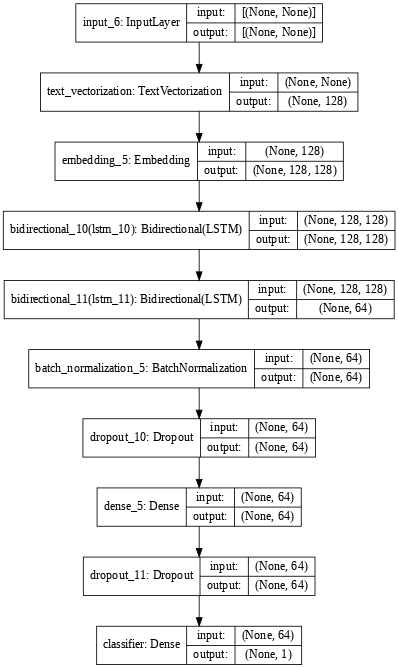

In [66]:
es_callback = tf.keras.callbacks.EarlyStopping(
          monitor='val_loss', 
          verbose=1, 
          patience=10, 
          mode='min', 
          restore_best_weights=True
          )

mck_callback = tf.keras.callbacks.ModelCheckpoint (
         filepath=model_checkpoint_path,
         save_weights_only=True,
         monitor='val_loss',
         mode='min',
         verbose=1,
         save_best_only=True
        )

lr_callback = printlearningrate() 

#optimizer = optimization.create_optimizer(
#      init_lr=init_lr,
#      num_train_steps=num_train_steps,
#      num_warmup_steps=num_warmup_steps,
#      optimizer_type='adamw'
#      )


lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate = init_lr,
    decay_steps=num_train_steps,
    end_learning_rate=end_lr,
    power=power,
)

#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    init_lr,
#    decay_steps=num_train_steps,
#    decay_rate=decay_rate)

optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)
lr_metric = get_lr_metric(optimizer)


METRICS = [
             keras.metrics.TruePositives(name='tp'),
             keras.metrics.FalsePositives(name='fp'),
             keras.metrics.TrueNegatives(name='tn'),
             keras.metrics.FalseNegatives(name='fn'), 
             keras.metrics.BinaryAccuracy(name='accuracy'),
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'),
             keras.metrics.AUC(name='auc', curve='ROC'),
             keras.metrics.AUC(name='prc', curve='PR'), 
             keras.metrics.PrecisionAtRecall(recall=0.95, name='pr_at_recall'),
             keras.metrics.SensitivityAtSpecificity(specificity=0.95,name='ss_at_sp'),
             lr_metric,
          ]


classifier_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=METRICS
    )

tf.keras.utils.plot_model(model=classifier_model, show_shapes=True, dpi=60)

###Train

In [62]:
#@title Load weights if available
#if os.path.exists(model_checkpoint_path):
#  print('loading saved weight')
#  classifier_model.load_weights(model_checkpoint_path)
#else:
#  print('No weight to initialize')

In [67]:
history = classifier_model.fit(
             x=train_ds,
             validation_data=val_ds,
             epochs=epochs,
             callbacks=[es_callback, mck_callback]
             )

Epoch 1/50
608/608 [==============================] - 117s 156ms/step - loss: 0.3188 - tp: 16358.0000 - fp: 1709.0000 - tn: 18064.0000 - fn: 2781.0000 - accuracy: 0.8846 - precision: 0.9054 - recall: 0.8547 - auc: 0.9479 - prc: 0.9453 - pr_at_recall: 0.7714 - ss_at_sp: 0.7848 - lr: 0.0460 - val_loss: 0.3059 - val_tp: 3734.0000 - val_fp: 330.0000 - val_tn: 3880.0000 - val_fn: 248.0000 - val_accuracy: 0.9294 - val_precision: 0.9188 - val_recall: 0.9377 - val_auc: 0.9760 - val_prc: 0.9664 - val_pr_at_recall: 0.9031 - val_ss_at_sp: 0.9116 - val_lr: 0.0421

Epoch 00001: val_loss improved from inf to 0.30595, saving model to /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/checkpoints/youtube_clickbait_finetuned_SEQ_all/youtube_clickbait_finetuned_SEQ_all_checkpoint
Epoch 2/50
608/608 [==============================] - 89s 146ms/step - loss: 0.2274 - tp: 17321.0000 - fp: 1161.0000 - tn: 18612.0000 - fn: 1818.0000 - accuracy: 0.9234 - precision: 0.9372 - re

In [80]:
# Save model weights
#classifier_model.save_weights(model_checkpoint_path)

#Plot train history

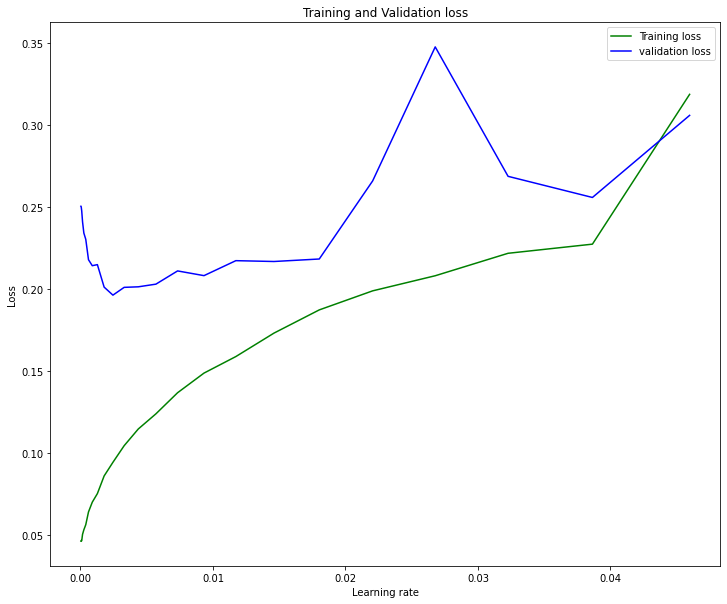

In [68]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
lr =  history.history['lr']
plt.plot(lr, loss_train, 'b', label='Training loss')
plt.plot(lr, loss_val, 'o', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Learning rate')
plt.ylabel('Loss')
plt.legend()
plt.show()

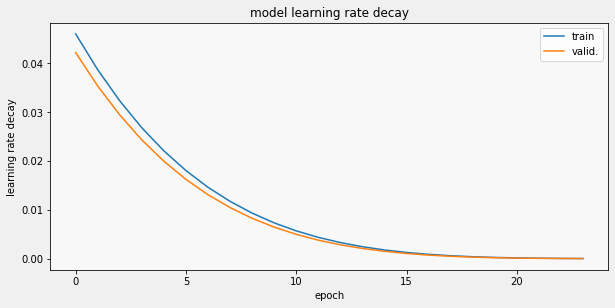

In [69]:
vh.display_training_curves(history.history['lr'], history.history['val_lr'], 'learning rate decay', 211)

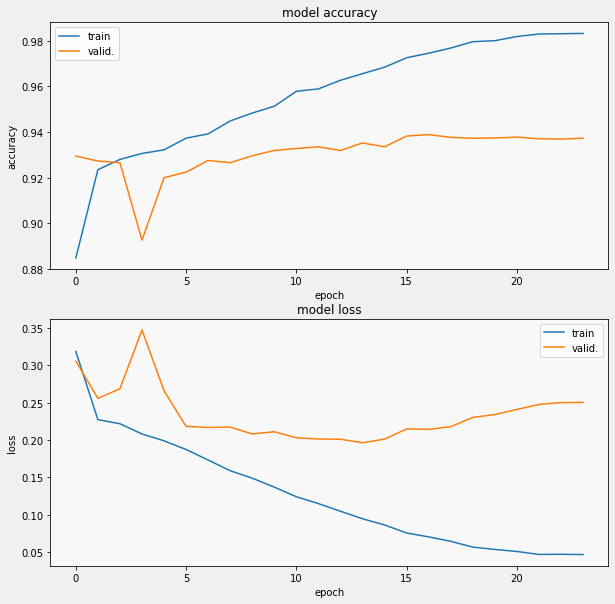

In [70]:
vh.display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
vh.display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

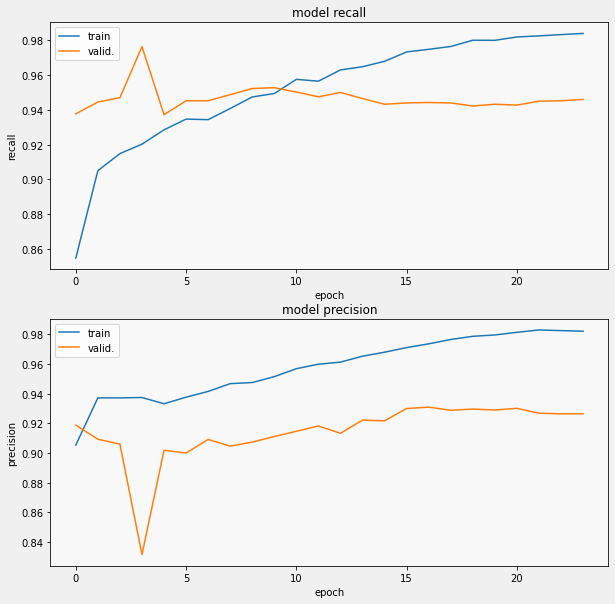

In [71]:
vh.display_training_curves(history.history['recall'], history.history['val_recall'], 'recall', 211)
vh.display_training_curves(history.history['precision'], history.history['val_precision'], 'precision', 212)

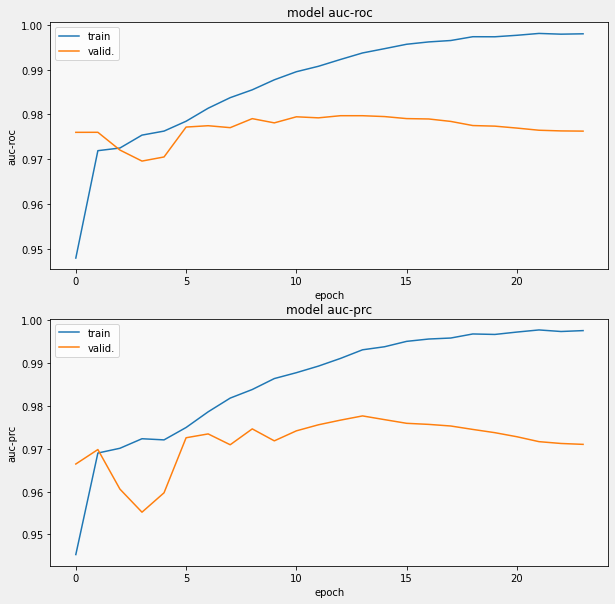

In [72]:
vh.display_training_curves(history.history['auc'], history.history['val_auc'], 'auc-roc', 211)
vh.display_training_curves(history.history['prc'], history.history['val_prc'], 'auc-prc', 212)

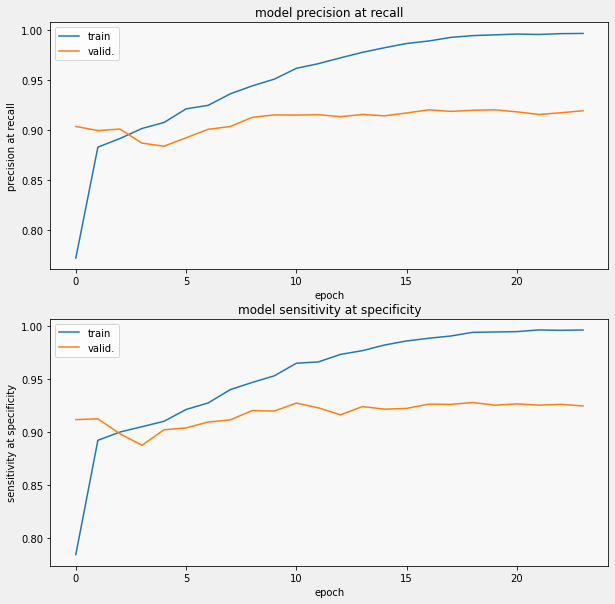

In [73]:
vh.display_training_curves(history.history['pr_at_recall'], history.history['val_pr_at_recall'], 'precision at recall', 211)
vh.display_training_curves(history.history['ss_at_sp'], history.history['val_ss_at_sp'], 'sensitivity at specificity', 212)

# Model Inference
We have trained the classifier, now let's use the trained model to infer the test dataset. Beside the test dataset, we also have benchmark dataset that we would also to see the eefectiveness of our model over benchmark dataset on predicting the clickbait's.

##Model Evaluation

###Evaluate Classifier on Test set

In [74]:
results_test_set = classifier_model.evaluate(test_ds)

for name, value in zip(classifier_model.metrics_names, results_test_set):
  print(name, ': ', value)
print()

30/30 [==============================] - 2s 64ms/step - loss: 0.2292 - tp: 863.0000 - fp: 94.0000 - tn: 929.0000 - fn: 34.0000 - accuracy: 0.9333 - precision: 0.9018 - recall: 0.9621 - auc: 0.9789 - prc: 0.9702 - pr_at_recall: 0.9242 - ss_at_sp: 0.9320 - lr: 2.3514e-05
loss :  0.22919300198554993
tp :  863.0
fp :  94.0
tn :  929.0
fn :  34.0
accuracy :  0.9333333373069763
precision :  0.9017763733863831
recall :  0.9620958566665649
auc :  0.9788792729377747
prc :  0.9701635837554932
pr_at_recall :  0.924160361289978
ss_at_sp :  0.9319955110549927
lr :  2.3514150598202832e-05



### Evaluate Classifier on Benchmarking set

In [75]:
results_benchmarking_set = classifier_model.evaluate(benchmark_ds)

for name, value in zip(classifier_model.metrics_names, results_benchmarking_set):
  print(name, ': ', value)
print()

2/2 [==============================] - 0s 75ms/step - loss: 1.2369 - tp: 39.0000 - fp: 2.0000 - tn: 51.0000 - fn: 36.0000 - accuracy: 0.7031 - precision: 0.9512 - recall: 0.5200 - auc: 0.8469 - prc: 0.9043 - pr_at_recall: 0.5859 - ss_at_sp: 0.5467 - lr: 2.3514e-05
loss :  1.2369180917739868
tp :  39.0
fp :  2.0
tn :  51.0
fn :  36.0
accuracy :  0.703125
precision :  0.9512194991111755
recall :  0.5199999809265137
auc :  0.8469181060791016
prc :  0.9043428897857666
pr_at_recall :  0.5859375
ss_at_sp :  0.54666668176651
lr :  2.3514156055171043e-05



##Export Model for inference

In [76]:
#classifier_model.save(saved_model_path, include_optimizer=False)

##Model prediction

In [77]:
#saved_classifier = keras.models.load_model(saved_model_path)

### Prediction for Test set

Accuracy: 0.933333
Precision: 0.901776
Recall: 0.962096
F1 score: 0.930960
ROC AUC: 0.935105
[[929  94]
 [ 34 863]]
Non clickbaits Detected (True Negatives):  929
Non-Clickbaits Detected as Clickbaits (False Positives):  94
Clickbaits Detected as Non-clickbaits (False Negatives):  34
Clickbaits Detected (True Positives):  863
Total Non-clickbaits:  1023
Total Clickbaits:  897



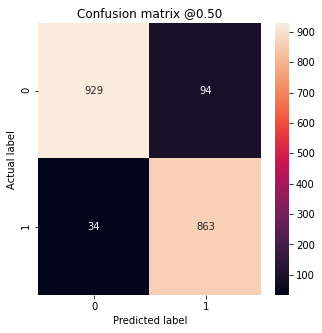

In [78]:
predict_on_test_dataset(classifier_model, test_ds, BATCH_SIZE=BATCH_SIZE)

### Prediction for Benchmarking set

Accuracy: 0.703125
Precision: 0.951220
Recall: 0.520000
F1 score: 0.672414
ROC AUC: 0.741132
[[51  2]
 [36 39]]
Non clickbaits Detected (True Negatives):  51
Non-Clickbaits Detected as Clickbaits (False Positives):  2
Clickbaits Detected as Non-clickbaits (False Negatives):  36
Clickbaits Detected (True Positives):  39
Total Non-clickbaits:  53
Total Clickbaits:  75



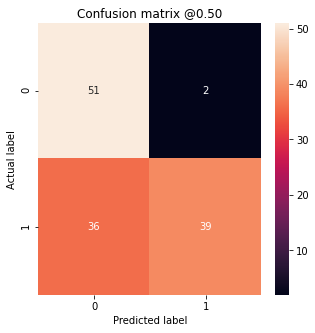

In [81]:
predict_on_test_dataset(classifier_model, benchmark_ds, BATCH_SIZE=BATCH_SIZE)